# Introduction

This project is attempt to assign ICD9 codes autonomously to clinical notes in eletronic medical records through machine learning models. 

### Data
The [MIMIC-III](https://github.com/MIT-LCP/mimic-code) dataset was used to train all models.  Since this was a multilabel text classification task, a fair amount of preprocessing was necessary.  Clinical notes were embedded (converted from text to a dense vector representation) with [word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) embeddings pretraiend on Google News and [BERT](https://arxiv.org/abs/1810.04805) embeddings pretrained on the MIMIC-III dataset.  Results using the BERT embeddings, though, have not yet been obtained.  ICD9 codes were grouped with the clinical notes on the `hadm_id` column in MIMIC-III.  This resulted in a varying number of ICD9 codes being associated with each clinical note (hence the multilabel classification task).  

Exploratory visualizations of the dataset can be found in [this](#visid) section.  

### Models

The baseline models trained for this task were a logistic regression, a random forest, and a multilayer perceptron.  The word2vec embeddings were element-wise averaged across all words in a given note to obtain a document representation.  

![](./images/lstm_colah.png)
A long short-term memory model was also trained using PyTorch in an attempt to leverage sequential relationships between words in clinical notes.

Results from the models that were trained can be found [here](#resid).

Note: LSTM image obtained from http://colah.github.io/posts/2015-08-Understanding-LSTMs/

# Read Data

In [8]:
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
import os
from typing import List, Set, Dict, Tuple
from utils import get_conn, query_aws, PROJ_DIR, TREE, V_CODE
import tqdm
import spacy
from itertools import chain
from collections import Counter
import torch
import math
import re
pd.set_option('display.max_colwidth', -1)
nlp = spacy.load("en_core_web_sm")

In [3]:
# read in list of all notes
notes_df = query_aws("select text from mimiciii.noteevents limit 50000")
notes = notes_df["text"].tolist()

In [9]:
# set data locations
datadir = os.path.join(PROJ_DIR, "data", "preprocessed")
imagedir = os.path.join(PROJ_DIR, "images")
modeldir = os.path.join(PROJ_DIR, "data", "models")

# load all processed data (with embeddings excluded)
df = pd.read_pickle(os.path.join(datadir, "visdata.pd"))

# load test data
test_df = pd.read_pickle(os.path.join(datadir, "test.pd"))
Y_test = test_df["roots"].tolist()
class_names = pd.read_csv(os.path.join(datadir, "class_names.csv"), 
                          header=None, squeeze=True).tolist()

In [10]:
# add root names to df
get_codes = lambda dummies: [class_names[i] for i, dum in enumerate(dummies) if dum]
df["root_names"] = df["roots"].apply(get_codes)

<a id="visid"></a>

# Exploratory Visualizations

In [26]:
from scripts.visdata import summary_table, note_lengths, icd_summary
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## Summary Tables

In [100]:
# load summary table data
summ_df = summary_table(query_aws)
row_order = ["Patients", "Admissions", "ICD9 Codes", "Deaths"]
col_order = ["Totals", "Male", "Female", "Private", "Medicare", "Medicaid", "Government", "Self Pay"]
summ_df = summ_df.loc[row_order, col_order]

/Users/cccdenhart/Documents/projects/icd_tagging/scripts/visdata.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  summary_df = pd.concat([totals_df, gender_df, insurance_df], axis=0)


In [107]:
summ_df

Category,Totals,Male,Female,Private,Medicare,Medicaid,Government,Self Pay
Patients,46520,26121,20399,19663,21002,4570,1614,600
Admissions,58976,32950,26026,22582,28215,5785,1783,611
ICD9 Codes,11501,5852,5649,5718,5023,3989,2657,1467
Deaths,5836,3141,2695,1372,3903,381,90,95


### ICD9 Summary
Due to the granularity of ICD9 codes, only the top level of codes in the ICD9 hierarchy were used for classification. They are summarized below.

In [102]:
all_roots = list(it.chain.from_iterable(df["root_names"].tolist()))
icd_table = icd_summary(all_roots, TREE)

In [108]:
icd_table

,Code,Mimic-iii Counts,Number of Leaves,Description
0,001-139,173037,871,INFECTIOUS AND PARASITIC DISEASES
1,140-239,56220,660,NEOPLASMS
2,240-279,256828,278,"ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS"
3,280-289,0,10,DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS
4,290-319,106277,307,MENTAL DISORDERS
5,320-389,153848,1334,DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS
6,390-459,334785,403,DISEASES OF THE CIRCULATORY SYSTEM
7,460-519,269565,217,DISEASES OF THE RESPIRATORY SYSTEM
8,520-579,192481,519,DISEASES OF THE DIGESTIVE SYSTEM
9,580-629,213352,382,DISEASES OF THE GENITOURINARY SYSTEM


## Categories

Clinical notes are binned (exclusively) into several different cateogories.  

In [22]:
query = "select category, count(row_id) from mimiciii.noteevents group by category;"
ccounts_df = query_aws(query)
ccounts_df.columns = ["Category", "Count"]
ccounts_df = ccounts_df.sort_values("Count", ascending=False)

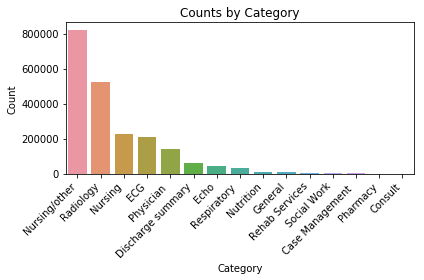

In [42]:
cat_fp = os.path.join(imagedir, "categories.png")
ax = sns.barplot(x="Category", y="Count", data=ccounts_df)
ax.set_title("Counts by Category")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.savefig(cat_fp)
plt.show()

## Distributions

In [63]:
icd_lens = [len(r) for r in df["root_names"].tolist()]
note_lens = notes_df["text"].apply(lambda s: len(re.findall(r'\w+', s)))
note_lens_mid = lens[lens.between(lens.quantile(.1), lens.quantile(.9))]

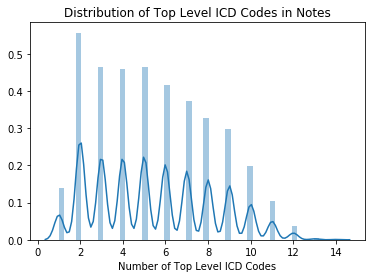

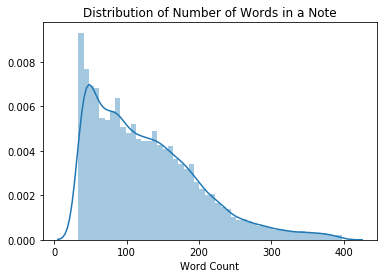

In [69]:
ax = sns.distplot(icd_lens)
ax.set(xlabel="Number of Top Level ICD Codes",
       title="Distribution of Top Level ICD Codes per Note")
plt.savefig(os.path.join(imagedir, "num_icd_codes.png"))
plt.show()

ax = sns.distplot(note_lens_mid)
ax.set_title("Distribution of Number of Words in a Note")
ax.set_xlabel("Word Count")
plt.savefig(os.path.join(imagedir, "word_counts.png"))

plt.show()

## ICD Codes by Insurance

In [60]:
# read data
query = """
SELECT admissions.hadm_id AS adm_id, count(diagnoses_icd.icd9_code) AS icd, array_agg(admissions.insurance)[1] AS insurance
FROM mimiciii.admissions AS admissions
JOIN mimiciii.diagnoses_icd AS diagnoses_icd
ON admissions.hadm_id = diagnoses_icd.hadm_id
GROUP BY admissions.hadm_id;
"""
insur_icd_df = query_aws(query)

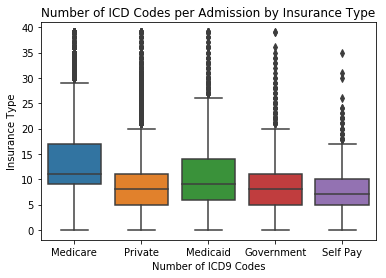

In [70]:
ax = sns.boxplot(x="insurance", y="icd", data=insur_icd_df)
ax.set(xlabel="Number of ICD9 Codes",
       ylabel="Insurance Type",
       title="Number of ICD Codes per Admission by Insurance Type")
plt.savefig(os.path.join(imagedir, "insurance.png"))
plt.show()

## Word Cloud

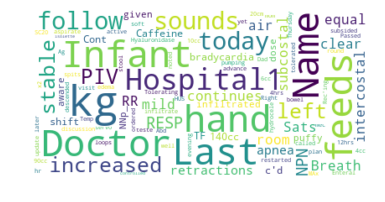

In [76]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(notes[15])
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(os.path.join(imagedir, "wordcloud.png"))
plt.show()

## Embedding Comparisons

In [11]:
from gensim.models import KeyedVectors
from transformers import AutoTokenizer, AutoModel

In [12]:
# load word2vec
w2v_fp = os.path.join(PROJ_DIR, "data", "embeddings", 
                      "GoogleNews-vectors-negative300.bin")
word2vec = KeyedVectors.load_word2vec_format(w2v_fp, binary=True)

# load bert
bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
bert.eval()
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [86]:
from torch.nn.utils.rnn import pad_sequence

In [85]:
T = [torch.tensor(tokenizer.encode(n, add_special_tokens=True)) for n in notes[0:31]]

In [87]:
pX = pad_sequence(T)

In [88]:
e = bert(pX)

<a id="resid"></a>

# Results

In [4]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from transformers import BertModel

## Load Classifiers

In [2]:
import joblib
from scripts.models import Clf, Lstm
from sklearn.base import BaseEstimator
from sklearn.metrics import (f1_score, precision_score, recall_score,
                             classification_report)
from scripts.evaluation import ml_accuracy, probs_to_preds

In [14]:
def predict(model, X: List[List[int]], threshold: float = 0.5) -> np.ndarray:
    """Give predictions for the given data."""
    probs = model(X)
    pos = torch.where(probs < threshold, probs, torch.ones(*probs.shape))
    neg = torch.where(pos > threshold, pos, torch.zeros(*probs.shape))
    preds = neg.long().numpy()
    return preds

def predict_proba(model, X: List[List[int]]) -> np.ndarray:
    """Get probabilities for the given data."""
    return model(X).detach().numpy()

In [21]:
# load base classifiers
clf_fns = ["LogisticRegression.sk", "RandomForest.sk", "MLP.sk"]
clfs = [Clf(joblib.load(os.path.join(modeldir, fn)), fn.split(".")[0]) 
        for fn in clf_fns]

In [22]:
# get predictionss for each clf
for clf in clfs:
    clf.set_preds(test_df["d2v"].tolist())
    clf.set_probs(test_df["d2v"].tolist())

In [13]:
# load lstms
lstm_w2v_fn = "Lstm_w2v1.pt"
lstm_w2v = Lstm(torch.tensor(word2vec.vectors))
lstm_w2v.load_state_dict(torch.load(os.path.join(modeldir, lstm_w2v_fn)))
lstm_w2v.eval()

Lstm(
  (embeddings): Embedding(3000000, 300)
  (lstm): LSTM(300, 128)
  (hidden2code): Linear(in_features=128, out_features=16, bias=True)
)

In [48]:
preds = []
for x in tqdm.tqdm(test_df["w2v_idx"].tolist()):
    preds.append(predict(lstm_w2v, [x]))

100%|██████████| 15000/15000 [04:08<00:00, 60.29it/s]


In [77]:
probs = []
for x in tqdm.tqdm(test_df["w2v_idx"].tolist()):
    probs.append(predict_proba(lstm_w2v, [x]))

100%|██████████| 15000/15000 [04:09<00:00, 60.05it/s]


In [79]:
clf = Clf(lstm_w2v, "Lstm_w2v")
clf.preds = preds
clf.probs = probs
clfs.append(clf)

## Performance Results

In [89]:
# get performance data
f1s = [f1_score(Y_test, clf.preds, average="weighted", zero_division=1) for clf in clfs]
precs = [precision_score(Y_test, clf.preds, average="weighted", zero_division=1) for clf in clfs]
recs = [recall_score(Y_test, clf.preds, average="weighted", zero_division=1) for clf in clfs]
metrics = f1s + precs + recs
met_labels = ["F1 Score"] * len(clfs)+ ["Precision"] * len(clfs) + ["Recall"] * len(clfs)
clf_names = [clf.name for clf in clfs] * 3

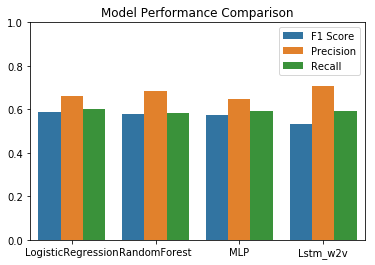

In [90]:
ax = sns.barplot(x=clf_names, y=metrics, hue=met_labels)
ax.set_ylim([0, 1])
ax.set(title="Model Performance Comparison")
plt.savefig("data/images/model_comparison.png")
plt.show()

## Classification Reports

In [91]:
class_reports = {clf.name: classification_report(Y_test, clf.preds, target_names=class_names, 
                                             zero_division=1, output_dict=True)
                 for clf in clfs}
crep_dfs = {name: pd.DataFrame(crep).T for name, crep in class_reports.items()}
crep_df = pd.concat(crep_dfs, axis=1)

In [92]:
crep_df

LogisticRegression                               Lstm_w2v  \
                       f1-score precision    recall  support  f1-score   
001-139       0.482014           0.626559  0.391660  5132.0   0.159748   
140-239       0.061664           0.757143  0.032141  1649.0   0.000000   
240-279       0.747290           0.665605  0.851828  7606.0   0.766350   
290-319       0.062518           0.516588  0.033272  3276.0   0.000000   
320-389       0.119231           0.522766  0.067289  4607.0   0.000000   
390-459       0.897409           0.840118  0.963085  10050.0  0.898871   
460-519       0.787083           0.730631  0.852988  8115.0   0.790140   
520-579       0.484314           0.615959  0.399032  5784.0   0.255832   
580-629       0.653559           0.629736  0.679254  6435.0   0.670921   
630-679       0.000000           1.000000  0.000000  1.0      0.000000   
680-709       0.007916           0.529412  0.003988  2257.0   0.000000   
710-739       0.008193           0.320000  0.004149  1928.0   0.000000   
760-779       0.931186           0.957214  0.906537  3381.0   0.945688   
780-799       0.520266           0.607055  0.455189  5936.0   0.390751   
800-999       0.658786           0.621687  0.700594  6563.0   0.674256   
V01-V91       0.693785           0.639446  0.758217  8458.0   0.662132   
micro avg     0.646073           0.694374  0.604055  81178.0  0.624317   
macro avg     0.444701           0.661245  0.443701  81178.0  0.388418   
weighted avg  0.589918           0.662198  0.604055  81178.0  0.535043   
samples avg   0.633812           0.716186  0.632514  81178.0  0.627256   

                                                MLP                      \
             precision    recall  support  f1-score precision    recall   
001-139       0.540449  0.093726  5132.0   0.419342  0.662737  0.306703   
140-239       1.000000  0.000000  1649.0   0.000000  1.000000  0.000000   
240-279       0.647331  0.938996  7606.0   0.765780  0.651276  0.929135   
290-319       1.000000  0.000000  3276.0   0.009042  0.357143  0.004579   
320-389       1.000000  0.000000  4607.0   0.016201  0.452381  0.008248   
390-459       0.839962  0.966667  10050.0  0.900535  0.845308  0.963483   
460-519       0.680402  0.942083  8115.0   0.754017  0.784497  0.725816   
520-579       0.548295  0.166840  5784.0   0.434725  0.604558  0.339385   
580-629       0.565329  0.825019  6435.0   0.632984  0.632248  0.633722   
630-679       1.000000  0.000000  1.0      0.000000  1.000000  0.000000   
680-709       1.000000  0.000000  2257.0   0.005277  0.352941  0.002658   
710-739       1.000000  0.000000  1928.0   0.000000  0.000000  0.000000   
760-779       0.954231  0.937297  3381.0   0.951055  0.942492  0.959775   
780-799       0.569127  0.297507  5936.0   0.514468  0.627760  0.435815   
800-999       0.561436  0.843821  6563.0   0.652676  0.627443  0.680024   
V01-V91       0.576974  0.776779  8458.0   0.718414  0.608892  0.875975   
micro avg     0.656687  0.594989  81178.0  0.640014  0.697176  0.591515   
macro avg     0.780221  0.424296  81178.0  0.423407  0.634355  0.429082   
weighted avg  0.706556  0.594989  81178.0  0.572556  0.648737  0.591515   
samples avg   0.682090  0.637963  81178.0  0.629854  0.714509  0.619924   

                      RandomForest                               
              support     f1-score precision    recall  support  
001-139       5132.0   0.422949     0.670758  0.308846  5132.0   
140-239       1649.0   0.028520     0.705882  0.014554  1649.0   
240-279       7606.0   0.743214     0.677863  0.822509  7606.0   
290-319       3276.0   0.065698     0.689024  0.034493  3276.0   
320-389       4607.0   0.173524     0.609948  0.101150  4607.0   
390-459       10050.0  0.894023     0.833161  0.964478  10050.0  
460-519       8115.0   0.788375     0.723658  0.865804  8115.0   
520-579       5784.0   0.444220     0.631898  0.342497  5784.0   
580-629       6435.0   0.632328     0.651450  0.614297  6435.0   
630-679

## Probability Distributions

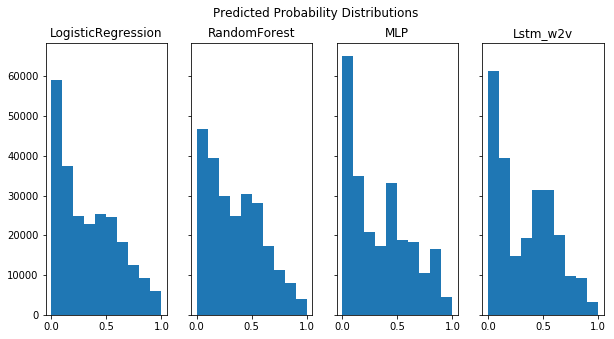

In [95]:
fig, axs = plt.subplots(1, len(clfs), sharey="all", sharex="all")
for ax, clf in zip(axs, clfs):
    ax.hist(np.array(clf.probs).flatten())
    ax.set(title=clf.name)
fig.set_size_inches(10, 5)
fig.suptitle("Predicted Probability Distributions")
plt.savefig("data/images/prob_dists.png")
plt.show()

## Precision/Recall Curves

In [96]:
def pr_curve(clf_name, probs, y_true, thresholds):
    """
    Generate precision/recall curve data for a given classifier.

    Implementation is custom because sklearn doesn't
    support multilabel classification for pr curve.
    """
    precs = []
    recs = []
    for thresh in tqdm.tqdm(thresholds):
        preds = probs_to_preds(probs, thresh)
        precs.append(precision_score(y_true, preds, average="weighted", zero_division=1))
        recs.append(recall_score(y_true, preds, average="weighted", zero_division=1))
    data = {"Classifier": [clf_name] * len(thresholds),
            "Precision": precs, 
            "Recall": recs, 
            "Threshold": thresholds}
    return pd.DataFrame(data)

In [97]:
# extract precision/recall data across thresholds
thresholds = np.linspace(0, 1, 10)
pr_dfs = [pr_curve(clf.name, clf.probs, Y_test, thresholds) for clf in clfs]
pr_df = pd.concat(pr_dfs)

100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


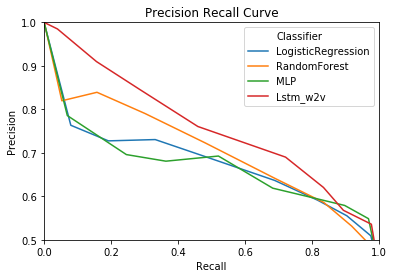

In [98]:
# plot precision recall curve for each classifier
ax = sns.lineplot(x="Recall", y="Precision", hue="Classifier", data=pr_df)
ax.set_ylim([0.5, 1])
ax.set_xlim([0, 1])
ax.set(title="Precision Recall Curve")
plt.savefig("data/images/prec_rec.png")
plt.show()